In [1]:
import itertools as it
import pandas as pd
import numpy as np
import xarray as xr
from numba import jit, guvectorize, int64, boolean
from matplotlib import pyplot as plt


Bad key axes.color_cycle in file /Users/Clara/.matplotlib/matplotlibrc, line 214 ('axes.color_cycle    : 348ABD, 7A68A6, A60628, 467821, CF4457, 188487, E24A33')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution
/Users/Clara/.virtualenvs/ow/lib/python3.9/site-packages/pandas/plotting/_matplotlib/boxplot.py:5: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  from matplotlib.artist import setp


In [2]:
rng = np.random.default_rng()

coordinate vars:

* opportunity (1-25)
* simulated match
* time to charge ult (in # of opportunities, 2-10?)
* valuation inaccuracy
* opportunity identification rate
* simulation #

data vars:
* expected/estimated value (1-99)
* realized value

In [3]:
n_matches = 1000
# n_matches = 10
n_simulations = 100
n_ult_opps = 25
min_true_value = 20
max_true_value = 100

ds = xr.Dataset(
    {
        'true_expected_value': (
            ['simulated_match', 'ult_opportunity'], 
            rng.integers(min_true_value, max_true_value, size=(n_matches, n_ult_opps)),
        ),
        'simulated_match': range(1, n_matches + 1),
        'ult_opportunity': range(1, n_ult_opps + 1),
        'opps_missed_while_charging': range(2, 11),
        'valuation_inaccuracy': range(0, 76, 15),
        'opp_identification_rate': range(5, 100, 15),
        'simulation_number': range(1, n_simulations + 1),
        'default_ult_strategy': [20, 40, 60, 80],
    }
)
ds

<xarray.Dataset>
Dimensions:                     (simulated_match: 1000, ult_opportunity: 25, opps_missed_while_charging: 9, valuation_inaccuracy: 6, opp_identification_rate: 7, simulation_number: 100, default_ult_strategy: 4)
Coordinates:
  * simulated_match             (simulated_match) int64 1 2 3 4 ... 998 999 1000
  * ult_opportunity             (ult_opportunity) int64 1 2 3 4 ... 22 23 24 25
  * opps_missed_while_charging  (opps_missed_while_charging) int64 2 3 ... 9 10
  * valuation_inaccuracy        (valuation_inaccuracy) int64 0 15 30 45 60 75
  * opp_identification_rate     (opp_identification_rate) int64 5 20 ... 80 95
  * simulation_number           (simulation_number) int64 1 2 3 4 ... 98 99 100
  * default_ult_strategy        (default_ult_strategy) int64 20 40 60 80
Data variables:
    true_expected_value         (simulated_match, ult_opportunity) int64 77 ....

In [4]:
ds.true_expected_value

<xarray.DataArray 'true_expected_value' (simulated_match: 1000, ult_opportunity: 25)>
array([[77, 84, 66, ..., 81, 53, 71],
       [25, 45, 97, ..., 52, 98, 28],
       [92, 66, 50, ..., 79, 34, 96],
       ...,
       [56, 26, 74, ..., 79, 30, 90],
       [94, 30, 59, ..., 53, 53, 78],
       [54, 54, 35, ..., 47, 79, 99]])
Coordinates:
  * simulated_match  (simulated_match) int64 1 2 3 4 5 ... 996 997 998 999 1000
  * ult_opportunity  (ult_opportunity) int64 1 2 3 4 5 6 7 ... 20 21 22 23 24 25

In [5]:
def simulate_valuation(ds):
    def _broadcast_simulated_ult_opportunities(var):
        return var.broadcast_like(ds.simulated_match).broadcast_like(ds.ult_opportunity).broadcast_like(ds.simulation_number)

    max_inaccuracy_offset = _broadcast_simulated_ult_opportunities(ds.valuation_inaccuracy.broadcast_like(ds.opp_identification_rate))
    min_valuation = xr.apply_ufunc(np.maximum, min_true_value // 2, ds.true_expected_value - max_inaccuracy_offset)
    max_valuation = xr.apply_ufunc(np.minimum, max_true_value, ds.true_expected_value + max_inaccuracy_offset)
    opp_valuation = xr.apply_ufunc(rng.integers, min_valuation, max_valuation + 1)

    opp_identification_rate = _broadcast_simulated_ult_opportunities(ds.opp_identification_rate.broadcast_like(ds.valuation_inaccuracy))
    opp_identification_mask = xr.apply_ufunc(rng.integers, xr.full_like(opp_identification_rate, 100)) < opp_identification_rate
    
    return opp_valuation * opp_identification_mask

In [6]:
ds = ds.assign(estimated_value=simulate_valuation)
ds

<xarray.Dataset>
Dimensions:                     (simulated_match: 1000, ult_opportunity: 25, opps_missed_while_charging: 9, valuation_inaccuracy: 6, opp_identification_rate: 7, simulation_number: 100, default_ult_strategy: 4)
Coordinates:
  * simulated_match             (simulated_match) int64 1 2 3 4 ... 998 999 1000
  * ult_opportunity             (ult_opportunity) int64 1 2 3 4 ... 22 23 24 25
  * opps_missed_while_charging  (opps_missed_while_charging) int64 2 3 ... 9 10
  * valuation_inaccuracy        (valuation_inaccuracy) int64 0 15 30 45 60 75
  * opp_identification_rate     (opp_identification_rate) int64 5 20 ... 80 95
  * simulation_number           (simulation_number) int64 1 2 3 4 ... 98 99 100
  * default_ult_strategy        (default_ult_strategy) int64 20 40 60 80
Data variables:
    true_expected_value         (simulated_match, ult_opportunity) int64 77 ....
    estimated_value             (simulated_match, ult_opportunity, simulation_number, opp_identification_rate, valuation_inaccuracy) int64 ...

In [7]:
# Loosen ult strategy near the end of the round
@jit
def adjust_ult_strategy(default_ult_strategy, reverse_opp_index):
    if reverse_opp_index == -1:
        return default_ult_strategy // 4
    elif reverse_opp_index >= -3:
        return default_ult_strategy // 2
    return default_ult_strategy

@guvectorize([(int64[:], int64, int64, boolean[:], boolean[:])], '(n),(),()->(n),(n)')
def simulate_ult_usage(estimated_value, default_ult_strategy, opps_missed_while_charging, ult_available, ult_used):
    ult_available.fill(False)
    ult_used.fill(False)

    n_ult_opps = len(estimated_value)
    opp_index = opps_missed_while_charging

    while opp_index < n_ult_opps:
        ult_available[opp_index] = True

        if estimated_value[opp_index] >= adjust_ult_strategy(default_ult_strategy, opp_index - n_ult_opps):
            ult_used[opp_index] = True
            opp_index += opps_missed_while_charging + 1
        else:
            opp_index += 1

In [8]:
simulate_ult_usage([15, 80, 90, 43, 70, 0, 99, 2, 50], 60, 1)

(array([False,  True, False,  True,  True, False,  True, False,  True]),
 array([False,  True, False, False,  True, False,  True, False,  True]))

In [9]:
ult_available, ult_used = xr.apply_ufunc(
    simulate_ult_usage, ds.estimated_value, ds.default_ult_strategy, ds.opps_missed_while_charging,
    input_core_dims=[['ult_opportunity'], [], []], output_core_dims=[['ult_opportunity'], ['ult_opportunity']]
)

display(ult_available)
display(ult_used)

<xarray.DataArray (simulated_match: 1000, simulation_number: 100, opp_identification_rate: 7, valuation_inaccuracy: 6, default_ult_strategy: 4, opps_missed_while_charging: 9, ult_opportunity: 25)>
array([[[[[[[False, False,  True, ...,  True,  True,  True],
            [False, False, False, ...,  True,  True,  True],
            [False, False, False, ...,  True,  True,  True],
            ...,
            [False, False, False, ...,  True,  True,  True],
            [False, False, False, ...,  True,  True,  True],
            [False, False, False, ...,  True,  True,  True]],

           [[False, False,  True, ...,  True,  True,  True],
            [False, False, False, ...,  True,  True,  True],
            [False, False, False, ...,  True,  True,  True],
            ...,
            [False, False, False, ...,  True,  True,  True],
            [False, False, False, ...,  True,  True,  True],
            [False, False, False, ...,  True,  True,  True]],

           [[False, False,  True, ...,  True,  True,  True],
            [False, False, False, ...,  True,  True,  True],
            [False, False, False, ...,  True,  True,  True],
            ...,
...
            ...,
            [False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False]],

           [[False, False,  True, ...,  True, False, False],
            [False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False],
            ...,
            [False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False]],

           [[False, False,  True, ...,  True, False, False],
            [False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False],
            ...,
            [False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False]]]]]]])
Coordinates:
  * simulated_match             (simulated_match) int64 1 2 3 4 ... 998 999 1000
  * ult_opportunity             (ult_opportunity) int64 1 2 3 4 ... 22 23 24 25
  * valuation_inaccuracy        (valuation_inaccuracy) int64 0 15 30 45 60 75
  * opp_identification_rate     (opp_identification_rate) int64 5 20 ... 80 95
  * simulation_number           (simulation_number) int64 1 2 3 4 ... 98 99 100
  * default_ult_strategy        (default_ult_strategy) int64 20 40 60 80
  * opps_missed_while_charging  (opps_missed_while_charging) int64 2 3 ... 9 10

<xarray.DataArray (simulated_match: 1000, simulation_number: 100, opp_identification_rate: 7, valuation_inaccuracy: 6, default_ult_strategy: 4, opps_missed_while_charging: 9, ult_opportunity: 25)>
array([[[[[[[False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False],
            ...,
            [False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False]],

           [[False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False],
            ...,
            [False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False]],

           [[False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False],
            ...,
...
            ...,
            [False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False],
            [False, False, False, ..., False, False, False]],

           [[False, False,  True, ...,  True, False, False],
            [False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False],
            ...,
            [False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False]],

           [[False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False],
            ...,
            [False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False],
            [False, False, False, ...,  True, False, False]]]]]]])
Coordinates:
  * simulated_match             (simulated_match) int64 1 2 3 4 ... 998 999 1000
  * ult_opportunity             (ult_opportunity) int64 1 2 3 4 ... 22 23 24 25
  * valuation_inaccuracy        (valuation_inaccuracy) int64 0 15 30 45 60 75
  * opp_identification_rate     (opp_identification_rate) int64 5 20 ... 80 95
  * simulation_number           (simulation_number) int64 1 2 3 4 ... 98 99 100
  * default_ult_strategy        (default_ult_strategy) int64 20 40 60 80
  * opps_missed_while_charging  (opps_missed_while_charging) int64 2 3 ... 9 10

In [10]:
realized_value = xr.dot(ds.true_expected_value, ult_used, dims='ult_opportunity')
realized_value

<xarray.DataArray (simulated_match: 1000, simulation_number: 100, opp_identification_rate: 7, valuation_inaccuracy: 6, default_ult_strategy: 4, opps_missed_while_charging: 9)>
array([[[[[[ 45,  45,  45, ...,   0,   0,   0],
           [ 45,  45,  45, ...,   0,   0,   0],
           [  0,   0,   0, ...,   0,   0,   0],
           [  0,   0,   0, ...,   0,   0,   0]],

          [[ 55,  55,  55, ...,  55,  55,  55],
           [ 55,  55,  55, ...,  55,  55,  55],
           [ 55,  55,  55, ...,  55,  55,  55],
           [  0,   0,   0, ...,   0,   0,   0]],

          [[ 71,  71,  71, ...,  71,  71,  71],
           [ 71,  71,  71, ...,  71,  71,  71],
           [  0,   0,   0, ...,   0,   0,   0],
           [  0,   0,   0, ...,   0,   0,   0]],

          [[  0,   0,   0, ...,   0,   0,   0],
           [  0,   0,   0, ...,   0,   0,   0],
           [  0,   0,   0, ...,   0,   0,   0],
           [  0,   0,   0, ...,   0,   0,   0]],

...

          [[404, 407, 257, ..., 161, 130,  97],
           [404, 407, 257, ..., 161, 130,  97],
           [380, 302, 277, ..., 161,  95, 117],
           [315, 315, 315, ..., 149, 149, 149]],

          [[476, 369, 329, ..., 117, 130,  97],
           [502, 369, 208, ..., 117, 130,  97],
           [392, 273, 230, ..., 117, 117, 117],
           [312, 312, 312, ..., 143, 143, 143]],

          [[476, 407, 329, ..., 117, 130,  97],
           [511, 296, 191, ..., 136,  91,  97],
           [432, 339, 301, ..., 136, 111, 117],
           [218, 183, 215, ..., 136,  97,  97]],

          [[489, 266, 329, ..., 161, 130,  97],
           [489, 305, 191, ..., 161,  91,  97],
           [264, 208, 211, ..., 111, 111, 117],
           [227, 200, 143, ..., 143, 143, 143]]]]]])
Coordinates:
  * simulated_match             (simulated_match) int64 1 2 3 4 ... 998 999 1000
  * valuation_inaccuracy        (valuation_inaccuracy) int64 0 15 30 45 60 75
  * opp_identification_rate     (opp_identification_rate) int64 5 20 ... 80 95
  * simulation_number           (simulation_number) int64 1 2 3 4 ... 98 99 100
  * default_ult_strategy        (default_ult_strategy) int64 20 40 60 80
  * opps_missed_while_charging  (opps_missed_while_charging) int64 2 3 ... 9 10

In [11]:
ds = ds.assign(ult_available=ult_available, ult_used=ult_used, realized_value=realized_value)
# ds.to_netcdf('simulation.nc')
ds.sizes

Frozen({'simulated_match': 1000, 'ult_opportunity': 25, 'opps_missed_while_charging': 9, 'valuation_inaccuracy': 6, 'opp_identification_rate': 7, 'simulation_number': 100, 'default_ult_strategy': 4})

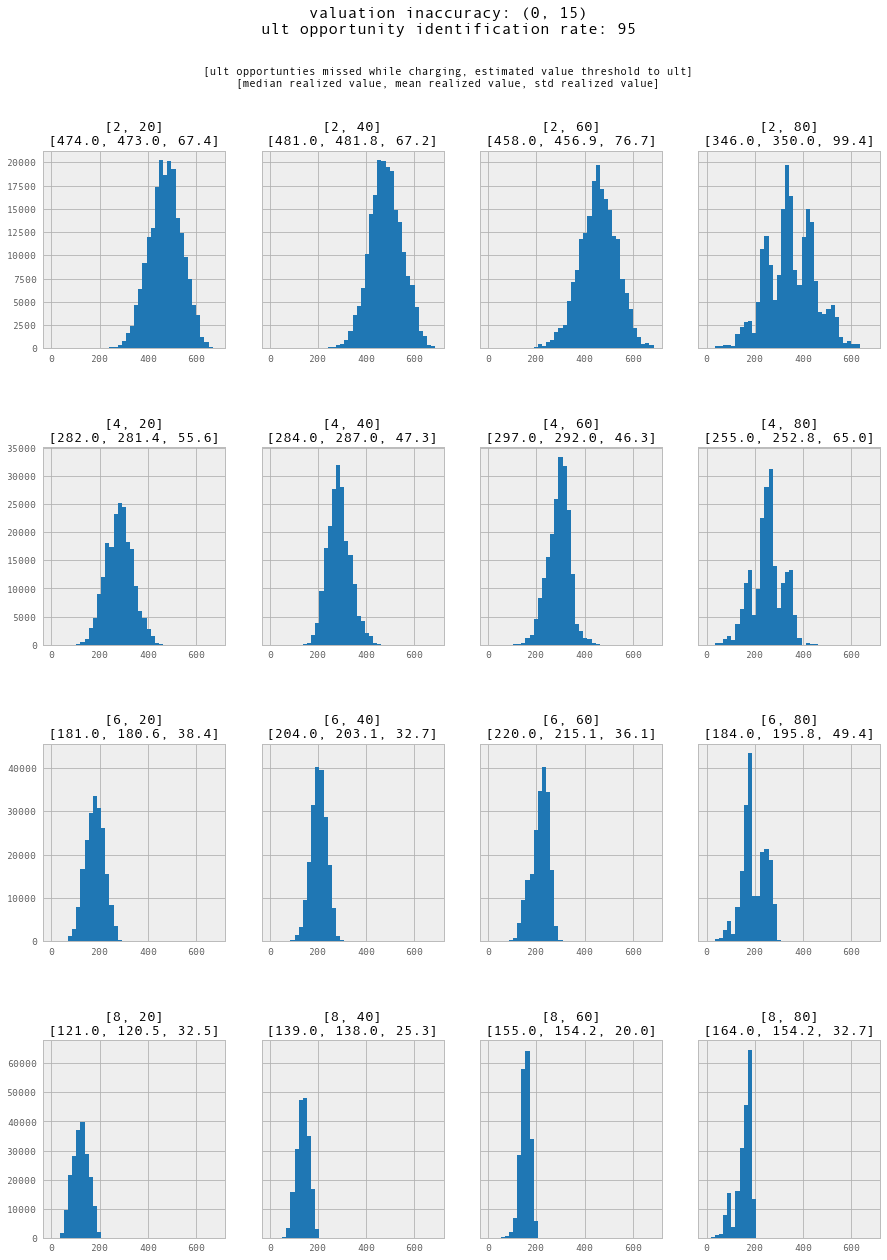

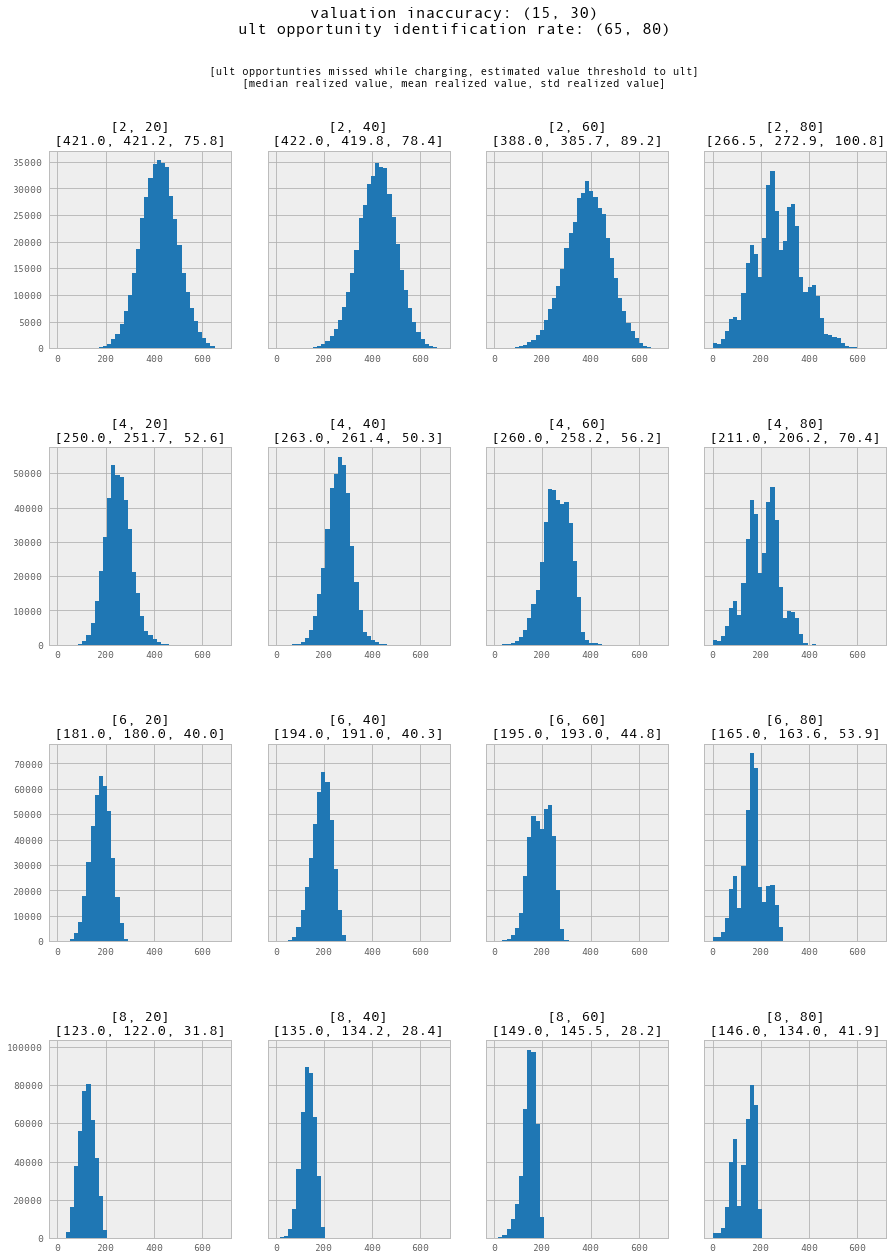

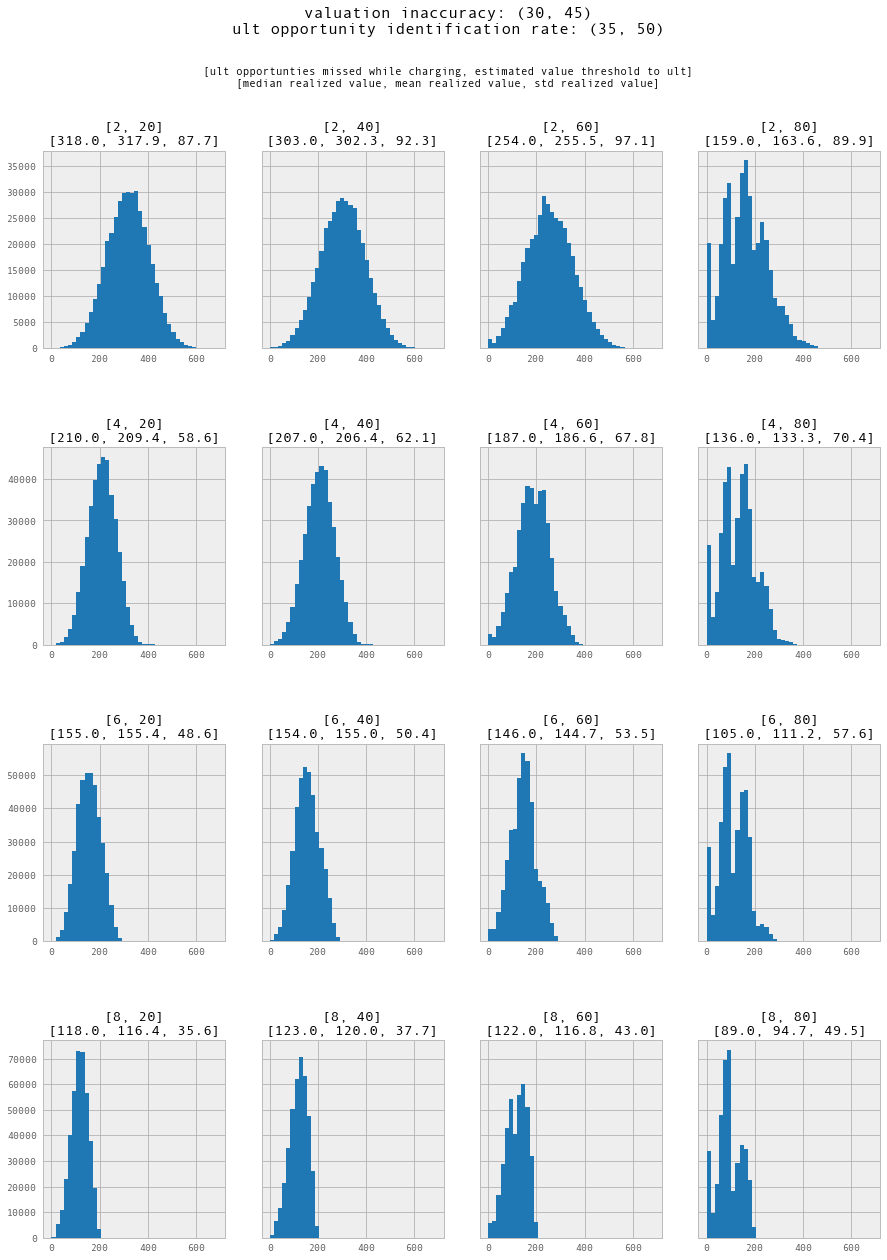

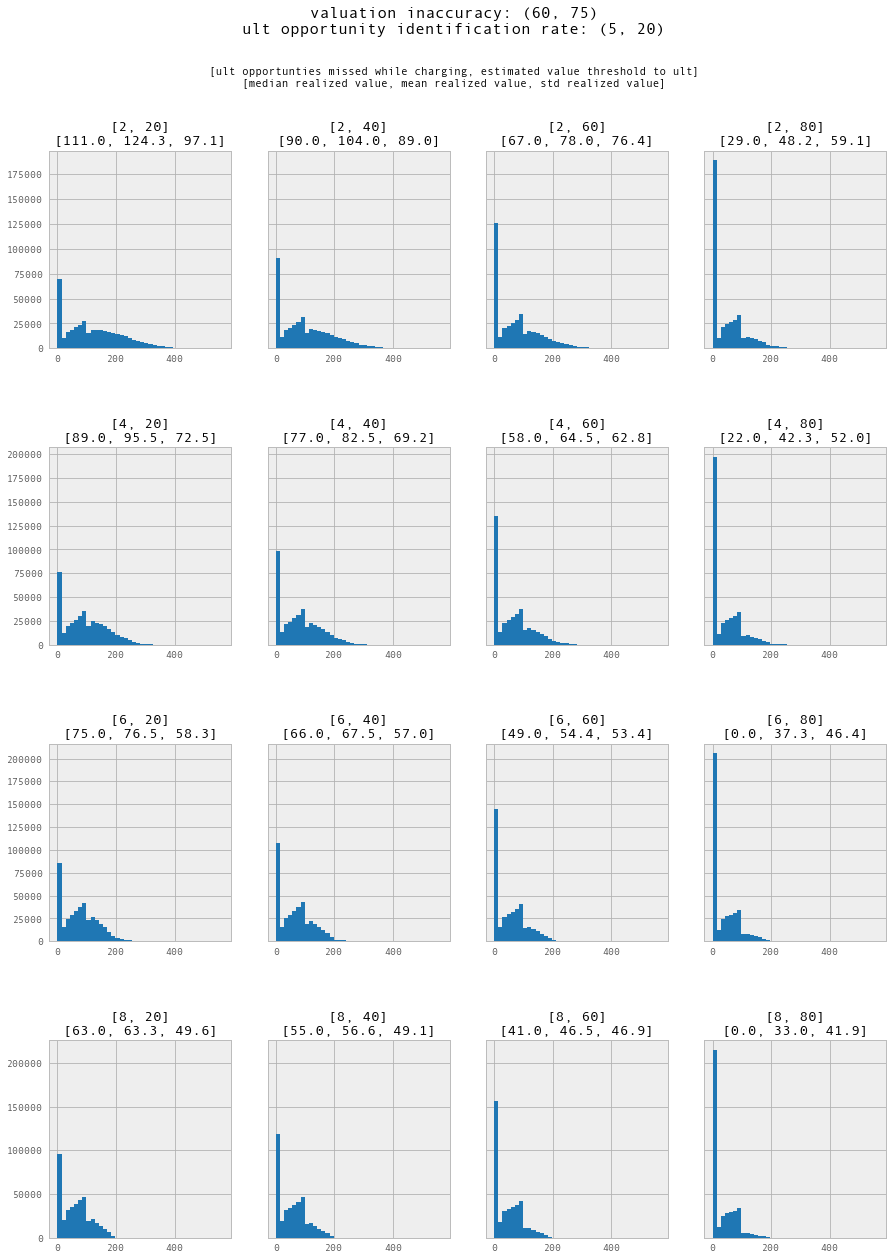

In [12]:
def _transform_to_slice(number_or_tuple):
    try:
        return slice(number_or_tuple[0], number_or_tuple[1] + 1)
    except TypeError:
        return number_or_tuple

def plot_variations_for_valuation_params(realized_value, valuation_inaccuracy, opp_identification_rate, bins=40):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 20), sharex=True, sharey='row')
    fig.suptitle('valuation inaccuracy: {0}\nult opportunity identification rate: {1}'.format(
        valuation_inaccuracy, opp_identification_rate), fontsize=16)
    fig.text(0.5, 0.925, ('[ult opportunties missed while charging, estimated value threshold to ult]\n'
                         '[median realized value, mean realized value, std realized value]'), 
             horizontalalignment='center', fontsize=11)

    plot_data = realized_value.sel(
        valuation_inaccuracy=_transform_to_slice(valuation_inaccuracy), 
        opp_identification_rate=_transform_to_slice(opp_identification_rate), 
    )
    max_realized_value = plot_data.max().item()

    for i, (opps_missed_while_charging, default_ult_strategy) in enumerate(it.product([2, 4, 6, 8], ds.default_ult_strategy.to_series())):
        ax = axes[i // 4, i % 4]
        subplot_data = plot_data.sel(
            default_ult_strategy=default_ult_strategy, 
            opps_missed_while_charging=opps_missed_while_charging
        )
        subplot_data.plot.hist(ax=ax, range=[0, max_realized_value], bins=bins)
        ax.set_title('[{0}, {1}]\n[{2}, {3}, {4}]'.format(
            opps_missed_while_charging, 
            default_ult_strategy,
            *map(lambda stat: round(getattr(subplot_data, stat)().item(), 1), ['median', 'mean', 'std'])
        ))
        ax.tick_params(labelbottom=True)

# 22.4M match simulations in the plots below
plot_variations_for_valuation_params(realized_value, valuation_inaccuracy=(0, 15), opp_identification_rate=95)
plot_variations_for_valuation_params(realized_value, valuation_inaccuracy=(15, 30), opp_identification_rate=(65, 80))
plot_variations_for_valuation_params(realized_value, valuation_inaccuracy=(30, 45), opp_identification_rate=(35, 50))
plot_variations_for_valuation_params(realized_value, valuation_inaccuracy=(60, 75), opp_identification_rate=(5, 20))


In [13]:
agg_dims = ['simulated_match', 'simulation_number']

ds = ds.assign(
    mean_realized_value=realized_value.mean(dim=agg_dims),
    median_realized_value=realized_value.median(dim=agg_dims),
    std_realized_value=realized_value.std(dim=agg_dims)
)
ds

<xarray.Dataset>
Dimensions:                     (simulated_match: 1000, ult_opportunity: 25, opps_missed_while_charging: 9, valuation_inaccuracy: 6, opp_identification_rate: 7, simulation_number: 100, default_ult_strategy: 4)
Coordinates:
  * simulated_match             (simulated_match) int64 1 2 3 4 ... 998 999 1000
  * ult_opportunity             (ult_opportunity) int64 1 2 3 4 ... 22 23 24 25
  * opps_missed_while_charging  (opps_missed_while_charging) int64 2 3 ... 9 10
  * valuation_inaccuracy        (valuation_inaccuracy) int64 0 15 30 45 60 75
  * opp_identification_rate     (opp_identification_rate) int64 5 20 ... 80 95
  * simulation_number           (simulation_number) int64 1 2 3 4 ... 98 99 100
  * default_ult_strategy        (default_ult_strategy) int64 20 40 60 80
Data variables:
    true_expected_value         (simulated_match, ult_opportunity) int64 77 ....
    estimated_value             (simulated_match, ult_opportunity, simulation_number, opp_identification_rate, valuation_inaccuracy) int64 ...
    ult_available               (simulated_match, simulation_number, opp_identification_rate, valuation_inaccuracy, default_ult_strategy, opps_missed_while_charging, ult_opportunity) bool ...
    ult_used                    (simulated_match, simulation_number, opp_identification_rate, valuation_inaccuracy, default_ult_strategy, opps_missed_while_charging, ult_opportunity) bool ...
    realized_value              (simulated_match, simulation_number, opp_identification_rate, valuation_inaccuracy, default_ult_strategy, opps_missed_while_charging) int64 ...
    mean_realized_value         (opp_identification_rate, valuation_inaccuracy, default_ult_strategy, opps_missed_while_charging) float64 ...
    median_realized_value       (opp_identification_rate, valuation_inaccuracy, default_ult_strategy, opps_missed_while_charging) float64 ...
    std_realized_value          (opp_identification_rate, valuation_inaccuracy, default_ult_strategy, opps_missed_while_charging) float64 ...